In [1]:
import config
import mysql.connector
from mysql.connector import errorcode
import requests
import json

#database string
endpoint = config.DatabaseEndpoint
name = config.DatabaseName
password = config.DatabasePassword
port = config.DatabasePort
cnx = mysql.connector.connect(
    host = endpoint,
    user = name,
    passwd = password,
)
cur = cnx.cursor()

TABLES = {}
TABLES['MarketShareByGenre'] ="""
CREATE TABLE MarketShareByGenre (
  Ranking INT,
  Genre VARCHAR(255) PRIMARY KEY,
  Movies INT,
  TotalBoxOffice BIGINT,
  Tickets BIGINT,
  Shares DECIMAL(10, 2)
)
"""


TABLES['GenreMarketByYear'] ="""
CREATE TABLE GenreMarketByYear (
  Year INT,
  MoviesInRelease INT,
  MarketShare DECIMAL(10, 2),
  Gross INT,
  TicketsSold INT,
  InflationAdjustedGross INT,
  TopGrossingMovie VARCHAR(255),
  GrossThatYear INT,
  Genre VARCHAR(255),
  Id VARCHAR(255) PRIMARY KEY
)
"""

MarketShareByGenreColumns = ['Ranking', 'Genre', 'Movies', 
                             'TotalBoxOffice', 'Tickets', 'Shares']

GenreMarketByYearColumns = ['Year', 'MoviesInRelease', 'MarketShare', 
            'Gross', 'TicketsSold', 'InflationAdjustedGross',
                     'TopGrossingMovie', 'GrossThatYear', 'Genre','Id']


add_GenreMarketByYear = ("INSERT INTO Movies.GenreMarketByYear"
                "(Year, MoviesInRelease, MarketShare, Gross, TicketsSold, "
                "InflationAjustedGross, TopGrossingMovie, GrossThatYear, Genre, Id)"
                "VALUES (%s, %s, %s, %s ,%s, %s, %s, %s, %s, %s)")

add_MarketShareByGenreColumns = ("INSTER INTO Movies.MarketShareByGenre"
                                 "(Ranking, Genre, Movies, TotalBoxOffice, Tickets, Shares)"
                                "VALUES (%s. %s, %s, %s, %s, %s)"

)

cnx.database = 'Movies'
#create tables
#create tables from dictionary
def create_tables(tables, cursor):
    for table_name in tables:
        table_description = tables[table_name]
        try:
            print("Creating table {}: ".format(table_name), end='')
            cursor.execute(table_description)
        except mysql.connector.Error as err:
            if err.errno == errorcode.ER_TABLE_EXISTS_ERROR:
                print('already exists')
            else:
                print(err.msg)
        else:
            print('OK')

create_tables(TABLES, cur)
cnx.commit()


Creating table MarketShareByGenre: already exists
Creating table GenreMarketByYear: already exists


In [2]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np

In [4]:
html_page = requests.get('https://www.the-numbers.com/market/genres')
soup = BeautifulSoup(html_page.content,'html.parser')
table=soup.find('table')


In [5]:
df=pd.read_html(str(table))[0]
df

,Rank,Genre,Movies,Total Box Office,Tickets,Share
0,1,Adventure,1064,"$63,774,679,468",9133100587,27.33%
1,2,Action,1027,"$47,445,372,974",6732270946,20.33%
2,3,Drama,5303,"$37,245,620,720",5708098460,15.96%
3,4,Comedy,2322,"$33,968,804,503",5233609995,14.56%
4,5,Thriller/Suspense,1088,"$19,523,571,613",2848683905,8.37%
5,6,Horror,602,"$11,746,135,344",1697782149,5.03%
6,7,Romantic Comedy,594,"$9,918,998,969",1599171071,4.25%
7,8,Musical,183,"$4,105,510,294",542119892,1.76%
8,9,Documentary,2319,"$2,237,329,848",336008169,0.96%
9,10,Black Comedy,187,"$1,662,663,471",231354541,0.71%


In [6]:
all_df = []
#get
for genre in df['Genre']:
    genre_url='https://www.the-numbers.com/market/genre/'+genre.replace('/','-or-').replace(' ','-')
    res=requests.get(genre_url)
    soup=BeautifulSoup(res.text,'html.parser')
    tables=soup.find_all('table')
    df2=pd.read_html(str(tables[1]))[0]
    df2['Genre']=genre
    all_df.append(df2)
for df in all_df:
        df['Id'] = df['Year'].apply(str).add(df['Genre'])



In [7]:
#clean       
for df in all_df:
    df['MarketShare'] = df['MarketShare'].replace({'%': ''}, regex=True)
    df['Gross'] = df['Gross'].replace({'\$' : ''}, regex=True)
    df['Inflation-AdjustedGross'] = df['Inflation-AdjustedGross'].replace({'\$' : ''}, regex=True)
    df['Gross that Year'] = df['Gross that Year'].replace({'\$' : ''}, regex=True)
    df['Gross'] = df['Gross'].replace({',':''}, regex = True)
    df['Inflation-AdjustedGross'] = df['Inflation-AdjustedGross'].replace({',':''}, regex = True)
    df['Gross that Year'] = df['Gross that Year'].replace({',':''}, regex = True)
    df['Year'] = df['Year'].astype(int)
    df['Movies inRelease'] = df['Movies inRelease'].astype(int)
    df['Gross'] = df['Gross'].astype(int)
    df['Tickets Sold'] = df['Tickets Sold'].astype(int)
    df['Inflation-AdjustedGross'] = df['Inflation-AdjustedGross'].astype('int32')
    df['Gross that Year'] = df['Gross that Year'].astype(int)
#all_df[0]['Year']
#all_df[0]['Movies inRelease']
all_df[0].columns

Index(['Year', 'Movies inRelease', 'MarketShare', 'Gross', 'Tickets Sold',
       'Inflation-AdjustedGross', 'Top-Grossing Movie', 'Gross that Year',
       'Genre', 'Id'],
      dtype='object')

In [13]:
type(all_df[0]['Year'][0])

numpy.int64

In [50]:
all_df[0]

,Year,Movies inRelease,MarketShare,Gross,Tickets Sold,Inflation-AdjustedGross,Top-Grossing Movie,Gross that Year,Genre,Id
0,1995,29,14.52,771507571,177358047,1615731808,Toy Story,150148222,Adventure,1995Adventure
1,1996,34,22.37,1290490033,291966054,-1635156544,Independence Day,306169255,Adventure,1996Adventure
2,1997,23,13.87,881902843,192135684,1750356081,Men in Black,250650052,Adventure,1997Adventure
3,1998,29,23.84,1614467732,344236174,-1158975751,Armageddon,201578182,Adventure,1998Adventure
4,1999,27,21.97,1612432107,317407880,-1403381509,Star Wars Ep. I: The Phanto…,430443350,Adventure,1999Adventure
5,2000,30,17.62,1327311892,246254507,-2051588737,How the Grinch Stole Christmas,253367455,Adventure,2000Adventure
6,2001,32,27.15,2268870844,400860557,-643127622,Harry Potter and the Sorcer…,300404434,Adventure,2001Adventure
7,2002,46,30.82,2822973523,485881821,131416093,Spider-Man,407677927,Adventure,2002Adventure
8,2003,46,26.37,2424131042,402011756,-632640199,Finding Nemo,339714367,Adventure,2003Adventure
9,2004,48,31.09,2887962704,465050334,-58358753,Shrek 2,441226247,Adventure,2004Adventure


In [9]:
import numpy as np

insert_GenreMarketByYear = (
                "INSERT INTO Movies.GenreMarketByYear"
                "(Year, MoviesInRelease, MarketShare, Gross, TicketsSold, "
                "InflationAdjustedGross, TopGrossingMovie, GrossThatYear, Genre, Id)"
                "VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
            )


for df in all_df:
    for idx, row in df.iterrows():
        #clean row
        year = df.iloc[idx][0] #int
        mir = df.iloc[idx][1] #int
        ms = df.iloc[idx][2] #decimal
        gross = df.iloc[idx][3] #int
        tS = df.iloc[idx][4] #int
        iAG = df.iloc[idx][5] #int
        tGM = df.iloc[idx][6] #string
        gTY = df.iloc[idx][7] #int
        G = df.iloc[idx][8] #string
        Id = df.iloc[idx][9] #string
        year = np.int64(year).item()
        mir = np.int64(mir).item()
        gross = np.int64(gross).item()
        tS = np.int64(tS).item()
        iAG = np.int64(iAG).item()
        gTY = np.int64(gTY).item()
        
        #push row
        data = [year, mir, ms, gross, tS, iAG, tGM, gTY, G, Id]
        cur.execute(insert_GenreMarketByYear, data)
        cnx.commit()

        
        
        
stuffs = [year, mir, ms, gross, tS, iAG, gTY, G, Id]

GenreMarketByYearColumns = ['Year', 'MoviesInRelease', 'MarketShare', 
            'Gross', 'TicketsSold', 'InflationAdjustedGross',
                     'TopGrossingMovie', 'GrossThatYear', 'Genre','Id']





In [9]:

cur.execute("""
SELECT *
FROM Movies.GenreMarketByYear
;
""")
# df8 = pd.DataFrame(cur.fetchall())
# df8.columns = [x[0] for x in cur.description]
# df8

In [10]:
import pandas as pd
df8 = pd.DataFrame(cur.fetchall())
df8.columns = [x[0] for x in cur.description]
df8

,Year,MoviesInRelease,MarketShare,Gross,TicketsSold,InflationAdjustedGross,TopGrossingMovie,GrossThatYear,Genre,Id
0,1995,29,19.75,1049544278,241274531,-2096956319,Batman Forever,184031112,Action,1995Action
1,1995,29,14.52,771507571,177358047,1615731808,Toy Story,150148222,Adventure,1995Adventure
2,1995,3,0.46,24185598,5559905,50650735,To Die For,21155211,Black Comedy,1995Black Comedy
3,1995,61,19.74,1048895722,241125423,-2098314692,Ace Ventura: When Nature Calls,104371496,Comedy,1995Comedy
4,1995,9,1.54,81994311,18849263,171716786,The Living Sea,64800000,Documentary,1995Documentary
...,...,...,...,...,...,...,...,...,...,...
317,2020,19,0.08,536156,58844,536069,Fantastic Fungi,129130,Documentary,2020Documentary
318,2020,34,18.84,118877603,13049119,118877474,Little Women,35211667,Drama,2020Drama
319,2020,6,2.96,18696499,2052302,18696471,The Grudge,9435020,Horror,2020Horror
320,2020,2,0.37,2317224,254359,2317210,Cats,2285285,Musical,2020Musical


In [31]:
df8_by_year = df8.groupby('Year').sum()
df8_by_year
df8_by_genre = df8.groupby('Genre').sum().sort_values("Gross")
df8_by_genre
#df8_by_genre_by_year = df8.groupby('Genre', 'Year').sum()

,Year,MoviesInRelease,Gross,TicketsSold,InflationAdjustedGross,GrossThatYear
Genre,,,,,,
Reality,4029,4,621696,73810,672409,326123
Multiple Genres,38185,42,33688583,4071085,37087585,27285269
Concert/Performance,42191,74,395155838,53881827,490863444,312623188
Western,44178,81,1084785441,149931395,1365875009,863793842
Black Comedy,52195,187,1662663471,231354541,2107639869,915197550
Documentary,52195,2319,2237329848,336008169,3061034420,773044433
Musical,50200,183,4105510294,542119892,4938712215,2428031776
Romantic Comedy,50175,594,9918998969,1599171071,14568448454,2718581089
Horror,52195,602,11746135344,1697782149,15466795378,2836127556


([array([0., 1., 1., 2., 0., 0., 1., 0., 0., 0.]),
  array([0., 0., 2., 2., 0., 0., 1., 0., 0., 0.]),
  array([0., 0., 2., 2., 0., 0., 0., 1., 0., 0.]),
  array([0., 0., 1., 2., 0., 0., 1., 1., 0., 0.]),
  array([0., 0., 2., 2., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 2., 2., 0., 0., 0., 0., 1., 0.]),
  array([1., 0., 1., 2., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 1., 3., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 1., 3., 0., 0., 0., 0., 0., 1.]),
  array([0., 0., 1., 1., 1., 0., 1., 0., 1., 0.]),
  array([0., 0., 1., 2., 0., 1., 0., 0., 1., 0.]),
  array([0., 0., 2., 2., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 1., 1., 1., 0., 0., 0., 0., 2.]),
  array([0., 0., 1., 1., 1., 1., 0., 0., 0., 1.]),
  array([0., 0., 2., 1., 1., 0., 0., 0., 0., 1.]),
  array([0., 0., 1., 1., 1., 0., 0., 0., 1., 1.]),
  array([0., 0., 1., 1., 1., 1., 0., 0., 0., 1.]),
  array([0., 0., 1., 1., 1., 1., 0., 0., 0., 1.]),
  array([0., 0., 1., 1., 1., 1., 0., 0., 0., 1.]),
  array([0., 0., 1., 2., 1., 0.

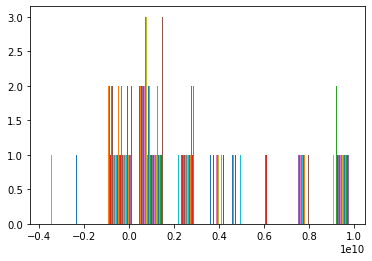

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(df8_by_year)

In [17]:
df8


,Year,MoviesInRelease,MarketShare,Gross,TicketsSold,InflationAdjustedGross,TopGrossingMovie,GrossThatYear,Genre,Id
0,1995,29,19.75,1049544278,241274531,-2096956319,Batman Forever,184031112,Action,1995Action
1,1995,29,14.52,771507571,177358047,1615731808,Toy Story,150148222,Adventure,1995Adventure
2,1995,3,0.46,24185598,5559905,50650735,To Die For,21155211,Black Comedy,1995Black Comedy
3,1995,61,19.74,1048895722,241125423,-2098314692,Ace Ventura: When Nature Calls,104371496,Comedy,1995Comedy
4,1995,9,1.54,81994311,18849263,171716786,The Living Sea,64800000,Documentary,1995Documentary
...,...,...,...,...,...,...,...,...,...,...
317,2020,19,0.08,536156,58844,536069,Fantastic Fungi,129130,Documentary,2020Documentary
318,2020,34,18.84,118877603,13049119,118877474,Little Women,35211667,Drama,2020Drama
319,2020,6,2.96,18696499,2052302,18696471,The Grudge,9435020,Horror,2020Horror
320,2020,2,0.37,2317224,254359,2317210,Cats,2285285,Musical,2020Musical


In [ ]:
# insert_GenreMarketByYear_2 = (
#                 "INSERT INTO Movies.GenreMarketByYear"
#                 "(Year, MoviesInRelease, MarketShare, Gross, TicketsSold, "
#                 "InflationAdjustedGross, TopGrossingMovie, GrossThatYear, Genre, Id)"
#                 "VALUES ({}, {}, {}, {}, {}, {}, {}, {}, {}, {})".format(
#                 year, mir, ms, gross, tS, iAG, tGM, gTY, G, Id)
#             )

# cur.execute(
#                 "INSERT INTO Movies.GenreMarketByYear"
#                 "(Year, MoviesInRelease, MarketShare, Gross, TicketsSold, "
#                 "InflationAdjustedGross, TopGrossingMovie, GrossThatYear, Genre, Id)"
#                 "VALUES ({}, {}, {}, {}, {}, {}, {}, {}, {}, {})".format(
#                 year, mir, ms, gross, tS, iAG, tGM, gTY, G, Id)
#             )

# cur.execute("INSERT INTO Movies.GenreMarketByYear 
#                 (Year, MoviesInRelease, MarketShare, Gross, TicketsSold, 
#                 InflationAdjustedGross, TopGrossingMovie, GrossThatYear, Genre, Id)
#             VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
# """.format(year, mir, ms, gross, tS, iAG, tGM, gTY, G, Id))



In [101]:
#### Insert actings credits to database from cleaned dataframe function ####
def insert_GenreMarketByYear(df):
#    i = 0
    for idx, row in df.iterrows():
        cur.execute(
                    """
                    INSERT INTO Movies.GenreMarketByYear 
                    (Year, MoviesInRelease, MarketShare, Gross, TicketsSold,
                    InflationAdjustedGross, TopGrossingMovie, GrossThatYear, Genre, Id)
                    VALUES ("{}", "{}", "{}", "{}", "{}", "{}", "{}", "{}", "{}", "{}")
                    """
                    .format(df.iloc[idx]['Year'],
                            df.iloc[idx]['Movies inRelease'], 
                            df.iloc[idx]['MarketShare'],
                            df.iloc[idx]['Gross'],
                            df.iloc[idx]['Tickets Sold'],
                            df.iloc[idx]['Inflation-AdjustedGross'],
                            df.iloc[idx]['Top-Grossing Movie'],
                            df.iloc[idx]['Gross That Year'],
                            df.iloc[idx]['Genre'],
                            df.iloc[idx]['Id'])
                    )
#        i += 1
#        if i % 1000 == 0:
#            print('Acting Credit {} inserted.'.format(i))
#    print('Done')
#    cnx.commit()
#insert_GenreMarketByYear(all_df[0])

KeyError: 'Gross That Year'

In [25]:
example = [(1, 'adventure', 1064, 63772981564, 9132914210, '27.33'),
            (2, 'adventur', 1065, 63772981565, 9132914211, '27.34')]

In [26]:
insertData(cur, add_MarketShareByGenreColumns, example)

MySQLInterfaceError: Python type tuple cannot be converted